# Gesture Recognition

In [1]:
# Increase notebook width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install --upgrade pip

In [3]:
!pip install visualkeras

In [4]:
!pip install pillow==9.5 # Any version above 9.5 for pillow results in exception during model visualization

In [5]:
!pip install tensorflow

In [6]:
!pip install Openpyxl

In [7]:
!pip install texttable

In [8]:
!pip install matplotlib

In [9]:
!pip install pydot

In [10]:
!pip install graphviz

In [11]:
import numpy as np
import os
import datetime
import os
import random as rn
import matplotlib.pyplot as plt
import imageio
from skimage.transform import resize, rescale
import visualkeras
from visualkeras import Layer
from PIL import Image, ImageFont

import tensorflow as tf
from tensorflow.keras import layers
from keras import callbacks
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, GlobalAveragePooling3D, GlobalAveragePooling2D
from keras.layers import ConvLSTM2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
from keras.applications import mobilenet
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras import backend as K
import warnings
warnings.filterwarnings('ignore')


import openpyxl
from openpyxl.styles import Font

from texttable import Texttable

We set the random seed so that the results don't vary drastically.

In [12]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

### Check if GPU is available

In [3]:
# tf.test.is_gpu_available()
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-01-09 04:54:08.034468: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-09 04:54:08.034528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


### Check TensorFlow version

In [4]:
tf.version.VERSION

'2.7.0'

In [13]:
# Ensure that the araial font file "Arial.ttf" is present in the location of this notebook. Link to file: https://github.com/techexorcist/gesture-recognition-deep-learning/blob/master/Arial.ttf
font = ImageFont.truetype("Arial.ttf", 70, encoding="unic")

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [18]:
# Number of output classes (Number of hand gestures considered)
num_classes = 5

# Default height of the image for the experiment
default_image_height = 120

# Default width of the image for the experiment
default_image_width = 120

# Default frame count for the experiment (Video has 30 frames)
default_frames_count = 30

# Default image count to be considered for the each model
default_num_images = 20

# Default value to indicate if augmentation is necessary for the model
default_perform_augment = False

# Default number of epoch
default_num_epochs = 30

# Default kernel size
default_kernel_size = (3,3,3)

# Default kernel size - CONV2D
default_kernel_size_conv2d = (3,3)

# Default pooling size
default_pool_size = (2,2,2)

# Default pooling size - CONV2D
default_pool_size_conv2d = (2,2)

# Default padding type
default_padding_type = "same"

# Default non-output layer activation function
default_layer_activation_func = "relu"

# Default output layer activation function
default_output_layer_activation_func = "softmax"

# Default model stride
default_stride = (1,1,1)

# Default model stride - CONV2D
default_stride_conv2d = (1,1)

# Default dropout value
default_dropout_value = 0.0

# Default hidden layer count
default_hidden_layer_count = 3

# Default hidden layer count - CONV2D
default_hidden_layer_count_conv2d = 4

# Default conv3d filters
default_conv3d_filters = (16, 32, 64, 128)

# Default conv2d filters
default_conv2d_filters = (16, 32, 64, 128, 256)

# Default dense layer count
default_dense_layer_count = 2

# Default dense layer filters
default_dense_filters = (256,128)

# Default channel value
default_channel_value = 3

# Default batch size for the experiment
default_batch_size = 10

# Default learning rate for the experiment
default_learning_rate = 0.002

# Default RNN cell count
default_rnn_cell_count = 64

# Default dense neuron count - RNN
default_dense_neuron_count = 64

# Default workbook filename
default_workbook_file_name = r"gesture_recognition_model_stats.xlsx"

# Default workbook worksheet name
default_worksheet_name = "model_details"

In [21]:
train_doc = np.random.permutation(open("/datasets/Project_data/train.csv").readlines())
val_doc = np.random.permutation(open("/datasets/Project_data/val.csv").readlines())
batch_size = default_batch_size

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = "/datasets/Project_data/train"
val_path = "/datasets/Project_data/val"
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = default_num_epochs
print ('# epochs =', num_epochs)

## Utility methods for the experiment

#### Method to plot model accuracy

In [8]:
def plot_model_accuracy(model_name, model_history):
    plt.plot(model_history.history['categorical_accuracy'])
    plt.plot(model_history.history['val_categorical_accuracy'])
    plt.title("MODEL ACCURACY for '{}'".format(model_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Method to plot model loss

In [9]:
def plot_model_loss(model_name, model_history):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title("MODEL LOSS for '{}'".format(model_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Method to configure callbacks

In [25]:
def initialise_model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=False,
#                                  save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto',
                                 period=1)

    LR = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.2,
                           patience=7,
                           verbose=1)

    earlyStopping = callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0,
                                            patience=7,
                                            verbose=1)
    
    return [checkpoint, LR, earlyStopping]

In [26]:
# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls
# it need to make.
def calculate_steps(batch_size):
    num_train_sequences = len(train_doc)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = num_train_sequences//batch_size
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    num_val_sequences = len(val_doc)
    if (num_val_sequences%batch_size) == 0:
        validation_steps = num_val_sequences//batch_size
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch, validation_steps

In [12]:
# Create workbook to document model details
from openpyxl.styles import colors
def create_workbook():
    workbook = openpyxl.Workbook()
    workbook.save(default_workbook_file_name)
    
    workbook = openpyxl.load_workbook(default_workbook_file_name)
    workbook["Sheet"].title = default_worksheet_name
    workbook.save(default_workbook_file_name)
    
    worksheet = workbook[default_worksheet_name]
    header = ("Model Name", "Model Details", "Total Parameters", "Trainable Parameters", "Non-Trainable Parameters", "Best Accuracy",
             "Best Val Accuracy", "Best Loss", "Best Val Loss", "Kernel Size", "Frames Per Video", "Image Height",
             "Image Width", "Epoch", "Batch Size", "Optimizer", "Is Augmented", "Learning Rate")
    worksheet.append(header)
    
    for header in worksheet["1:1"]: 
        header.font = Font(color = "2ECC71", bold=True, size=12)
        
    workbook.save(default_workbook_file_name)

In [13]:
def write_model_details_worksheet(model_name, model_details, total_params, train_params, non_train_params, best_acc,
                                  best_val_acc, best_loss, best_val_loss, kernel_size, frames_per_video,
                                  image_height, image_width, epoch, batch_size, optimizer, is_augment, learning_rate):
    workbook = openpyxl.load_workbook(default_workbook_file_name)
    worksheet = workbook[default_worksheet_name]
    
    new_row = (model_name, model_details, total_params, train_params, non_train_params, best_acc,
               best_val_acc, best_loss, best_val_loss, kernel_size, frames_per_video,
               image_height, image_width, epoch, batch_size, optimizer, is_augment, learning_rate)
    worksheet.append(new_row)
    
    workbook.save(default_workbook_file_name)

In [14]:
def read_model_worksheet_full():
    workbook = workbook = openpyxl.load_workbook(default_workbook_file_name)
    worksheet = workbook[default_worksheet_name]
    
    full_sheet_as_list = list(worksheet.values)
    
    workbook.close()
    return full_sheet_as_list

In [15]:
def print_worksheet_full():
    table = Texttable(max_width=180)
    table.add_rows(read_model_worksheet_full())
    print(table.draw())

In [19]:
create_workbook()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [19]:
# Utility for image transformation
image_data_generator = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [22]:
def generate(batch_size = batch_size, num_images_per_video=default_num_images, image_height=default_image_height,
             image_width=default_image_width, augment=default_perform_augment, is_validation=False):
    source_path = train_path
    folder_list = train_doc
    
    if is_validation:
        source_path = val_path
        folder_list = val_doc

    while True:
        folder_shuffle = np.random.permutation(folder_list)
        num_batches = len(folder_shuffle)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, default_frames_count), num_images_per_video)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,default_frames_count-1,num_images_per_video)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images_per_video, image_height, image_width, default_channel_value)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ folder_shuffle[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ folder_shuffle[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (image_height, image_width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = image_data_generator.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(folder_shuffle[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_shuffle)%batch_size):
            remaining_batch_size = len(folder_shuffle)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images_per_video, image_height, image_width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ folder_shuffle[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ folder_shuffle[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (image_height, image_width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = image_data_generator.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                
                batch_labels[folder, int(folder_shuffle[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [23]:
def verify_layer_details(num_layers, filters, is_dense=False):
    if is_dense:
        return num_layers == len(filters)
    else:
        return num_layers == len(filters)-1


def build_conv3D_model(num_hidden_layers=default_hidden_layer_count, conv3d_filters=default_conv3d_filters,
                       kernel_size=default_kernel_size, strides=default_stride,
                       num_dense_layers=default_dense_layer_count, dense_layer_filters=default_dense_filters,
                       dropout_val = default_dropout_value, num_images_per_video=default_num_images,
                       image_height=default_image_height, image_width=default_image_width, learning_rate = default_learning_rate):
    model = Sequential()
    
    is_valid_layer_details = verify_layer_details(num_hidden_layers, conv3d_filters)
    is_valid_dense_layer_details = verify_layer_details(num_dense_layers, dense_layer_filters, is_dense=True)
    
    print("Layer:{} --- Dense:{}".format(is_valid_layer_details, is_valid_dense_layer_details))
    
    # Input layer
    model.add(Conv3D(conv3d_filters[0], kernel_size, padding=default_padding_type,
                     input_shape=(num_images_per_video, image_height, image_width, default_channel_value)))
    model.add(Activation(default_layer_activation_func))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=default_pool_size))

    # Build hidden layers
    for x in range(num_hidden_layers):
        model.add(Conv3D(conv3d_filters[x+1], kernel_size, padding=default_padding_type))
        model.add(Activation(default_layer_activation_func))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=default_pool_size))
    
    model.add(Flatten())
                  
    # Build dense layers
    for x in range(num_dense_layers):
        model.add(Dense(dense_layer_filters[x]))
        model.add(Activation(default_layer_activation_func))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_val))

    model.add(Dense(num_classes))
    model.add(Activation(default_output_layer_activation_func))

    # Now that you have written the model, the next step is to `compile` the model. 
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

When you print the `summary` of the model, you'll see the total number of parameters you have to train.

## <center>Model-25: Model-23 with GRU cell size as 64 and drop-out value 0.5</center>

| Hidden Layer Count | CONV2D Filter | Kernel Size | Stride | Dense layer Count | Dense Layer Filter | Dropout Value | Frames per Video considered | Image Height | Image Width | Padding | Epochs | Batch Size | Augmentation | Optimizer | Loss | Metric | Learning Rate |
| --- | --- | --- |  --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | (64) | - | 1 | 1 | 64 | 0.5 | 20 | 120 | 120 | same | 20 | 20 | False | Adam | categorical_crossentropy | categorical_accuracy | 0.001

In [100]:
mobilenet_transfer = mobilenet.MobileNet(weights="imagenet", include_top=False)

class RNNCNN_MobileNet_GRU_All_Wts():
    
    def define_model(self,gru_cells=default_rnn_cell_count, 
                     dense_neurons=default_dense_neuron_count, 
                     dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(default_num_images, default_image_height, default_image_width, default_channel_value)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [101]:
model_name = "Model-25"

callback_list = initialise_model_callbacks(model_name)

steps_per_epoch, validation_steps = calculate_steps(batch_size=20)

train_generator = generate(batch_size=20, image_height=120, image_width=120)

val_generator   = generate(batch_size=20, image_height=120, image_width=120, is_validation=True)

In [102]:
model_25=RNNCNN_MobileNet_GRU_All_Wts()
model_25=model_25.define_model(dropout=0.5)
model_25.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeD  (None, 20, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_30 (TimeD  (None, 20, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_31 (TimeD  (None, 20, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_32 (TimeD  (None, 20, 1024)          0         
 istributed)                                                     
                                                                 
 gru_3 (GRU)                 (None, 64)              

### Model-25 layer representation

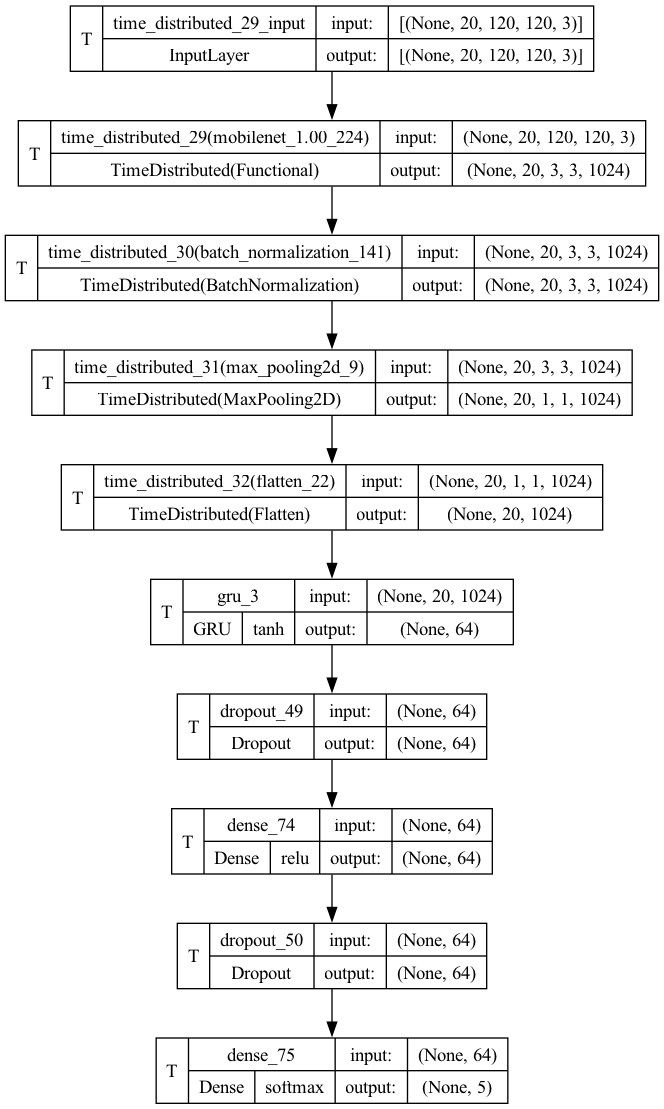

In [103]:
plot_model(model_25, to_file=model_name+".png", show_shapes=True, show_layer_names=True, show_layer_activations=True, show_trainable=True)

In [104]:
history = model_25.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                             callbacks=callback_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6285 - categorical_accuracy: 0.3514
Epoch 00001: saving model to Model-25_2024-01-0721_06_33.138633/model-00001-1.62847-0.35143-1.01678-0.77000.h5
34/34 [==============================] - 133s 4s/step - loss: 1.6285 - categorical_accuracy: 0.3514 - val_loss: 1.0168 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9564 - categorical_accuracy: 0.6440
Epoch 00002: saving model to Model-25_2024-01-0721_06_33.138633/model-00002-0.95639-0.64404-0.57783-0.83000.h5
34/34 [==============================] - 127s 4s/step - loss: 0.9564 - categorical_accuracy: 0.6440 - val_loss: 0.5778 - val_categorical_accuracy: 0.8300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.5725 - categorical_accuracy: 0.7903
Epoch 00003: saving model to Model-25_2024-01-0721_06_33.138633/model-00003-0.57247-0.79035-0.37962-0.88000.h5
34/34 [========

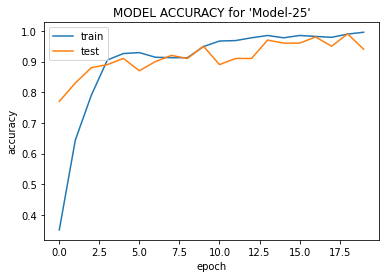

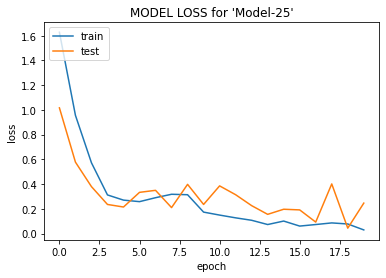

In [105]:
plot_model_accuracy(model_name, history)
plot_model_loss(model_name, history)

In [106]:
# Fetch statistics for populating model statistics workbook
total_params = model_25.count_params()
trainable_params = np.sum([K.count_params(w) for w in model_25.trainable_weights])
non_trainable_params = np.sum([K.count_params(w) for w in model_25.non_trainable_weights])

best_model_loss = min(history.history["loss"])
index_best_model_loss = history.history["loss"].index(best_model_loss)
best_model_cat_acc = history.history["categorical_accuracy"][index_best_model_loss]
best_model_val_cat_acc = history.history["val_categorical_accuracy"][index_best_model_loss]
best_model_val_loss = history.history["val_loss"][index_best_model_loss]

In [107]:
write_model_details_worksheet(model_name, "Model-23 with GRU cell size as 64 and drop-out value 0.5",
                              total_params, trainable_params, non_trainable_params, best_model_cat_acc,
                             best_model_val_cat_acc, best_model_loss, best_model_val_loss, "-", 20,
                             120, 120, 20, 20, "Adam", False, 0.001)

In [104]:
# print_worksheet_full()